<a href="https://colab.research.google.com/github/R-Damanhuri/Machine-Learning/blob/main/Caregiver-Recommendation/Model-Development/Fixed-Model/Newest_Caregiver_Model_City_Weight_with_LLMN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_hub as hub

In [2]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 124.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xar

#Custom Function

In [3]:
def fitScaler(data):
  scaler = StandardScaler()
  scaler.fit(data)
  return scaler

In [4]:
def get_id(output):
  sorted_index = np.argsort(-np.array(output), axis=0).reshape(-1) #dimulai dari 0

  sorted_index = [idx + 1 for idx in sorted_index] #plus 1 karena id caregiver tidak dimulai dari 0
  return sorted_index

In [5]:
def preprocess_city(city):
  lowered = city.lower()
  lowered.replace("kota", "").replace("kabupaten", "")
  return lowered

In [6]:
def gen_user_vecs(user_vec, num_item):
    user_vecs = [user_vec] * num_item
    return user_vecs

#Data

In [7]:
#Clone repository
!git clone https://github.com/R-Damanhuri/Machine-Learning.git

Cloning into 'Machine-Learning'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 112 (delta 1), reused 0 (delta 0), pack-reused 99
Receiving objects: 100% (112/112), 1.98 MiB | 12.23 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [8]:
# Read excel file with sheet name
cbf_dataset = pd.read_excel('/content/Machine-Learning/Caregiver-Recommendation/Data-Collecting/CareGiver_Recommender_Dataset.xlsx', 
              sheet_name=['Dataset Lansia','Dataset Caregiver'])

## Lansia

In [9]:
# Get DataFrame from Dict
lansia_df = cbf_dataset.get('Dataset Lansia')

In [10]:
lansia_df.shape

(2000, 22)

In [11]:
lansia_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   id                                       2000 non-null   int64 
 1   Mobilitas                                2000 non-null   int64 
 2   Penyakit lain                            2000 non-null   int64 
 3   Hipertensi                               2000 non-null   int64 
 4   Diabetes                                 2000 non-null   int64 
 5   Reumatik                                 2000 non-null   int64 
 6   Penyakit jantung                         2000 non-null   int64 
 7   Asma                                     2000 non-null   int64 
 8   Stroke                                   2000 non-null   int64 
 9   Mengurus rumah                           2000 non-null   int64 
 10  Membantu pergerakan dan aktivitas fisik  2000 non-null   int

In [12]:
lansia_df.head()

,id,Mobilitas,Penyakit lain,Hipertensi,Diabetes,Reumatik,Penyakit jantung,Asma,Stroke,Mengurus rumah,...,Mengecek kesehatan rutin secara mandiri,Mendampingi dan menjaga,Memasangkan alat medis khusus,Memeriksakan rutin ke dokter,Indonesia,Inggris,Jawa,Sunda,Melayu,Kota
0,1,1,0,0,0,0,0,0,0,3,...,2,4,1,1,1,1,1,1,0,KABUPATEN PEMALANG
1,2,2,1,1,0,0,0,0,0,3,...,2,4,3,3,0,0,0,1,0,KABUPATEN NDUGA
2,3,1,0,1,0,1,0,0,1,4,...,4,1,4,4,1,0,1,1,0,KOTA MAKASSAR
3,4,1,0,0,0,0,0,0,1,3,...,1,1,3,1,0,0,0,1,1,KABUPATEN BANYUWANGI
4,5,5,0,0,0,0,0,0,0,1,...,3,2,1,2,1,1,0,0,1,KABUPATEN ACEH UTARA


## Caregiver

In [13]:
# Get DataFrame from Dict
caregiver_df = cbf_dataset.get('Dataset Caregiver')

In [14]:
caregiver_df.shape

(2000, 22)

In [15]:
caregiver_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   id                                       2000 non-null   int64  
 1   Jenis kelamin                            2000 non-null   int64  
 2   Pendidikan terakhir                      2000 non-null   int64  
 3   Lama pengalaman (tahun)                  2000 non-null   int64  
 4   Jumlah lansia pernah dirawat             2000 non-null   int64  
 5   Umur                                     2000 non-null   int64  
 6   Keahlian                                 2000 non-null   float64
 7   Mengurus rumah                           2000 non-null   int64  
 8   Membantu pergerakan dan aktivitas fisik  2000 non-null   int64  
 9   Membantu konsumsi obat dan makanan       2000 non-null   int64  
 10  Mengecek kesehatan rutin secara mandiri  2000 no

In [16]:
caregiver_df

,id,Jenis kelamin,Pendidikan terakhir,Lama pengalaman (tahun),Jumlah lansia pernah dirawat,Umur,Keahlian,Mengurus rumah,Membantu pergerakan dan aktivitas fisik,Membantu konsumsi obat dan makanan,...,Memasangkan alat medis khusus,Memeriksakan rutin ke dokter,Indonesia,Inggris,Jawa,Sunda,Melayu,Kota,Gaji,Matching
0,1,1,5,12,4,33,0.14,0,0,1,...,1,1,1,1,0,0,0,KOTA BANDAR LAMPUNG,1060000,0.618680
1,2,1,5,13,12,36,0.43,1,0,1,...,1,0,1,1,1,0,1,KABUPATEN BOJONEGORO,830000,0.604606
2,3,0,1,1,1,24,0.71,0,1,1,...,0,1,1,1,0,0,0,KOTA SORONG,1590000,0.675971
3,4,0,2,4,0,39,0.86,1,1,1,...,1,1,1,0,0,1,0,KABUPATEN KEPULAUAN SULA,1820000,0.646133
4,5,0,1,2,0,35,0.00,1,0,0,...,0,1,1,0,0,1,0,KABUPATEN SERDANG BEDAGAI,1930000,0.956317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,0,1,0,0,21,1.00,1,0,1,...,0,1,1,0,0,1,0,KABUPATEN DOGIYAI,840000,0.914220
1996,1997,0,1,3,1,31,0.00,1,1,1,...,0,0,0,1,1,0,1,KABUPATEN MAMBERAMO TENGAH,1730000,0.977283
1997,1998,0,1,6,6,28,0.43,0,1,1,...,1,1,0,0,0,0,0,KABUPATEN JAYAPURA,620000,0.677816
1998,1999,0,1,6,2,31,0.29,0,1,1,...,0,0,1,1,1,1,1,KABUPATEN KUTAI KARTANEGARA,1690000,1.000000


## Kota

In [17]:
#Get DataFrame from csv
kota_df = pd.read_csv("/content/Machine-Learning/Caregiver-Recommendation/Data-Collecting/Kota.csv")

In [18]:
kota_df.shape

(514, 1)

In [19]:
kota_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   kota    514 non-null    object
dtypes: object(1)
memory usage: 4.1+ KB


In [20]:
caregiver_df['Kota'].value_counts()

KOTA SOLOK                  10
KABUPATEN LOMBOK TENGAH     10
KABUPATEN NGAWI              9
KABUPATEN PASANGKAYU         9
KABUPATEN LUWU               8
                            ..
KABUPATEN MOROWALI UTARA     1
KOTA BEKASI                  1
KABUPATEN BIAK NUMFOR        1
KOTA MAGELANG                1
KABUPATEN MEMPAWAH           1
Name: Kota, Length: 503, dtype: int64

In [21]:
caregiver_df[caregiver_df['Kota']=="KABUPATEN NGAWI"]

,id,Jenis kelamin,Pendidikan terakhir,Lama pengalaman (tahun),Jumlah lansia pernah dirawat,Umur,Keahlian,Mengurus rumah,Membantu pergerakan dan aktivitas fisik,Membantu konsumsi obat dan makanan,...,Memasangkan alat medis khusus,Memeriksakan rutin ke dokter,Indonesia,Inggris,Jawa,Sunda,Melayu,Kota,Gaji,Matching
118,119,1,5,2,1,31,1.00,1,1,0,...,0,0,0,0,1,1,0,KABUPATEN NGAWI,510000,0.889372
119,120,1,3,7,1,31,0.14,1,0,1,...,1,1,1,0,1,0,0,KABUPATEN NGAWI,1540000,1.000000
134,135,1,5,2,2,25,0.71,0,0,1,...,1,0,1,1,1,1,0,KABUPATEN NGAWI,1650000,0.805179
327,328,1,5,1,1,39,0.14,0,0,1,...,0,0,1,0,1,0,0,KABUPATEN NGAWI,1760000,0.785513
669,670,1,5,4,3,33,0.43,1,0,0,...,1,0,1,1,1,0,0,KABUPATEN NGAWI,880000,0.583016
808,809,1,3,5,5,27,0.29,1,1,0,...,1,1,0,0,0,1,0,KABUPATEN NGAWI,910000,0.833757
880,881,1,5,0,0,26,0.71,0,0,1,...,1,1,0,1,0,1,0,KABUPATEN NGAWI,1390000,1.000000
887,888,1,2,0,0,24,0.43,1,0,1,...,0,1,0,0,0,1,1,KABUPATEN NGAWI,1890000,0.637941
1420,1421,0,1,6,5,27,0.71,0,1,0,...,0,0,1,0,0,1,1,KABUPATEN NGAWI,820000,0.893833


# Feature Selection

In [22]:
#Separating numeric, city, and target features

lansia_num = lansia_df.loc[:, ~lansia_df.columns.isin(['id','Kota'])].copy()
caregiver_num = caregiver_df.loc[:, ~caregiver_df.columns.isin(['id', 'Matching','Kota'])].copy()

lansia_city = lansia_df.loc[:, lansia_df.columns == 'Kota'].copy()
caregiver_city = caregiver_df.loc[:, caregiver_df.columns == 'Kota'].copy()

y_matching = caregiver_df.loc[:, caregiver_df.columns == 'Matching'].copy()

In [23]:
lansia_num.columns

Index(['Mobilitas', 'Penyakit lain', 'Hipertensi', 'Diabetes', 'Reumatik',
       'Penyakit jantung', 'Asma', 'Stroke', 'Mengurus rumah',
       'Membantu pergerakan dan aktivitas fisik',
       'Membantu konsumsi obat dan makanan',
       'Mengecek kesehatan rutin secara mandiri', 'Mendampingi dan menjaga',
       'Memasangkan alat medis khusus', 'Memeriksakan rutin ke dokter',
       'Indonesia', 'Inggris', 'Jawa', 'Sunda', 'Melayu'],
      dtype='object')

In [24]:
caregiver_num.columns

Index(['Jenis kelamin', 'Pendidikan terakhir', 'Lama pengalaman (tahun)',
       'Jumlah lansia pernah dirawat', 'Umur', 'Keahlian', 'Mengurus rumah',
       'Membantu pergerakan dan aktivitas fisik',
       'Membantu konsumsi obat dan makanan',
       'Mengecek kesehatan rutin secara mandiri', 'Mendampingi dan menjaga',
       'Memasangkan alat medis khusus', 'Memeriksakan rutin ke dokter',
       'Indonesia', 'Inggris', 'Jawa', 'Sunda', 'Melayu', 'Gaji'],
      dtype='object')

In [25]:
lansia_city.head()

,Kota
0,KABUPATEN PEMALANG
1,KABUPATEN NDUGA
2,KOTA MAKASSAR
3,KABUPATEN BANYUWANGI
4,KABUPATEN ACEH UTARA


In [26]:
caregiver_city.head()

,Kota
0,KOTA BANDAR LAMPUNG
1,KABUPATEN BOJONEGORO
2,KOTA SORONG
3,KABUPATEN KEPULAUAN SULA
4,KABUPATEN SERDANG BEDAGAI


In [27]:
caregiver_city

,Kota
0,KOTA BANDAR LAMPUNG
1,KABUPATEN BOJONEGORO
2,KOTA SORONG
3,KABUPATEN KEPULAUAN SULA
4,KABUPATEN SERDANG BEDAGAI
...,...
1995,KABUPATEN DOGIYAI
1996,KABUPATEN MAMBERAMO TENGAH
1997,KABUPATEN JAYAPURA
1998,KABUPATEN KUTAI KARTANEGARA


# Preprocessing

## Numeric

In [28]:
#Create and fit scaler
#Then transform the numeric data

scalerLansia = fitScaler(lansia_num)
lansia_num_scaled = scalerLansia.transform(lansia_num)

scalerCaregiver = fitScaler(caregiver_num)
caregiver_num_scaled = scalerCaregiver.transform(caregiver_num)

In [29]:
lansia_num_scaled

array([[-1.42256822, -0.33518212, -0.79959006, ...,  0.98905984,
         1.04292026, -0.98412598],
       [-0.70264503,  2.98345271,  1.25064086, ..., -1.01106117,
         1.04292026, -0.98412598],
       [-1.42256822, -0.33518212,  1.25064086, ...,  0.98905984,
         1.04292026, -0.98412598],
       ...,
       [ 0.01727816, -0.33518212, -0.79959006, ..., -1.01106117,
         1.04292026, -0.98412598],
       [ 0.01727816, -0.33518212, -0.79959006, ..., -1.01106117,
         1.04292026, -0.98412598],
       [ 0.73720134, -0.33518212, -0.79959006, ..., -1.01106117,
        -0.95884608,  1.01613007]])

In [30]:
caregiver_num_scaled

array([[ 0.81394741,  1.33180301,  1.50560429, ..., -1.0502616 ,
        -0.98412598, -0.49512321],
       [ 0.81394741,  1.33180301,  1.72607644, ..., -1.0502616 ,
         1.01613007, -1.0234384 ],
       [-1.2285806 , -1.19833807, -0.91958932, ..., -1.0502616 ,
        -0.98412598,  0.72229874],
       ...,
       [-1.2285806 , -1.19833807,  0.18277141, ..., -1.0502616 ,
        -0.98412598, -1.50581314],
       [-1.2285806 , -1.19833807,  0.18277141, ...,  0.95214374,
         1.01613007,  0.952001  ],
       [-1.2285806 , -0.5658028 , -0.91958932, ..., -1.0502616 ,
        -0.98412598,  0.97497123]])

In [31]:
lansia_input = lansia_num_scaled
caregiver_input = caregiver_num_scaled

## City

In [32]:
list_lansia_city = lansia_city['Kota'].tolist()
list_caregiver_city = caregiver_city['Kota'].tolist()

In [33]:
list_lansia_city = [kota.lower() for kota in list_lansia_city]
list_caregiver_city = [kota.lower() for kota in list_caregiver_city]

In [34]:
list_lansia_city

['kabupaten pemalang',
 'kabupaten nduga',
 'kota makassar',
 'kabupaten banyuwangi',
 'kabupaten aceh utara',
 'kabupaten labuhanbatu utara',
 'kota tual',
 'kabupaten sumbawa',
 'kabupaten lima puluh kota',
 'kabupaten agam',
 'kabupaten penukal abab lematang ilir',
 'kabupaten semarang',
 'kota bau bau',
 'kabupaten indragiri hilir',
 'kabupaten nagan raya',
 'kabupaten empat lawang',
 'kabupaten sarolangun',
 'kabupaten bombana',
 'kabupaten seluma',
 'kabupaten kolaka utara',
 'kabupaten dompu',
 'kota tegal',
 'kabupaten mamuju',
 'kabupaten kampar',
 'kabupaten minahasa utara',
 'kabupaten banyuasin',
 'kabupaten klaten',
 'kabupaten jeneponto',
 'kabupaten tana toraja',
 'kota pagar alam',
 'kabupaten teluk bintuni',
 'kabupaten jembrana',
 'kabupaten sumba timur',
 'kabupaten buru selatan',
 'kota tasikmalaya',
 'kabupaten batu bara',
 'kabupaten tanah datar',
 'kabupaten penukal abab lematang ilir',
 'kota adm. jakarta utara',
 'kabupaten kepulauan sula',
 'kota sukabupatenum

In [35]:
list_caregiver_city

['kota bandar lampung',
 'kabupaten bojonegoro',
 'kota sorong',
 'kabupaten kepulauan sula',
 'kabupaten serdang bedagai',
 'kabupaten seram bagian timur',
 'kabupaten berau',
 'kabupaten adm. kep. seribu',
 'kota prabumulih',
 'kabupaten bantul',
 'kabupaten belu',
 'kabupaten jember',
 'kabupaten indragiri hulu',
 'kabupaten gresik',
 'kabupaten soppeng',
 'kota surakarta',
 'kabupaten bengkulu utara',
 'kabupaten bekasi',
 'kabupaten banyuwangi',
 'kabupaten dharmasraya',
 'kabupaten ogan ilir',
 'kabupaten asahan',
 'kabupaten boyolali',
 'kabupaten belitung timur',
 'kabupaten seruyan',
 'kabupaten tegal',
 'kabupaten bantul',
 'kabupaten raja ampat',
 'kabupaten buru',
 'kabupaten tanjung jabung barat',
 'kabupaten toba',
 'kabupaten lampung tengah',
 'kabupaten humbang hasundutan',
 'kabupaten pasangkayu',
 'kota pematangsiantar',
 'kabupaten deli serdang',
 'kabupaten banjarnegara',
 'kabupaten lombok tengah',
 'kabupaten murung raya',
 'kabupaten kolaka utara',
 'kabupaten be

# Model Numeric

In [36]:
n_outputs = 30
n_lansia_features = lansia_input.shape[1]
n_caregiver_features = caregiver_input.shape[1]

tf.random.set_seed(1)

In [37]:
#Lansia Numerical

#Tingkat 1
inlayer_lansia = tf.keras.layers.Input(shape=(n_lansia_features))

#Tingkat 2
final_vu = tf.keras.layers.Dense(n_outputs, activation = 'relu')(inlayer_lansia)


In [38]:
#Caregiver numerical

#Tingkat 1
inlayer_caregiver = tf.keras.layers.Input(shape=(n_caregiver_features))

#Tingkat 2
final_vm = tf.keras.layers.Dense(n_outputs, activation = 'relu')(inlayer_caregiver)

In [39]:
# Compute the dot product of the vectors vu and vm

dot = tf.keras.layers.Dot(axes=1, normalize=True)([final_vu, final_vm])

afterDot_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.02)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(n_outputs, activation = 'relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

output= afterDot_NN(dot)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 19)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 30)           630         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 30)           600         ['input_2[0][0]']                
                                                                                            

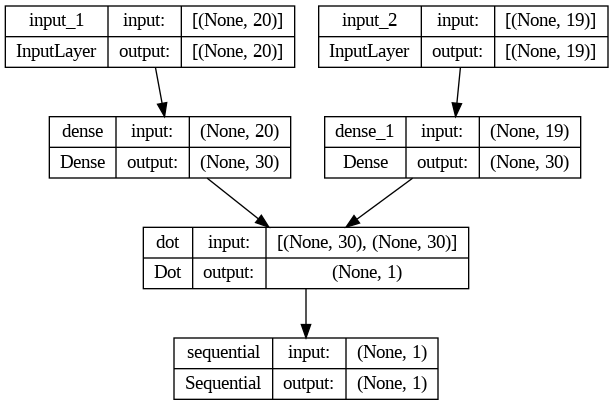

In [41]:
# Specify the inputs and output of the model
model = tf.keras.Model([inlayer_lansia, inlayer_caregiver], output)

model.summary()
plot_model(model, show_shapes=True, to_file='/content/Machine-Learning/Caregiver-Recommendation/Model-Development/Fixed-Model/content_based_model.png')

In [42]:
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss=cost_fn,
              metrics = [tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()])

# Training and Validation

In [43]:
caregiver_train, caregiver_test= train_test_split(caregiver_input,random_state = 42, train_size=0.8)
lansia_train, lansia_test= train_test_split(lansia_input,random_state = 42, train_size=0.8)

y_train, y_test= train_test_split(y_matching, random_state = 42, train_size=0.8)

In [44]:
print("lansia train: ", lansia_train.shape)
print("lansia test: ", lansia_test.shape)
print("caregiver train: ", caregiver_train.shape)
print("caregiver test: ", caregiver_test.shape)

print("\ny train: ", y_train.shape)
print("y test: ", y_test.shape)

lansia train:  (1600, 20)
lansia test:  (400, 20)
caregiver train:  (1600, 19)
caregiver test:  (400, 19)

y train:  (1600, 1)
y test:  (400, 1)


In [45]:
# tf.random.set_seed(1)

history = model.fit([lansia_train, caregiver_train], y_train, epochs=70, batch_size = 64, validation_data = ([lansia_test, caregiver_test], y_test))

Epoch 1/70
25/25 [==============================] - 1s 9ms/step - loss: 1.4185 - mean_absolute_error: 0.3078 - root_mean_squared_error: 0.3394 - val_loss: 1.3961 - val_mean_absolute_error: 0.3086 - val_root_mean_squared_error: 0.3404
Epoch 2/70
25/25 [==============================] - 0s 3ms/step - loss: 1.3697 - mean_absolute_error: 0.3000 - root_mean_squared_error: 0.3323 - val_loss: 1.3477 - val_mean_absolute_error: 0.3002 - val_root_mean_squared_error: 0.3328
Epoch 3/70
25/25 [==============================] - 0s 2ms/step - loss: 1.3226 - mean_absolute_error: 0.2924 - root_mean_squared_error: 0.3256 - val_loss: 1.3011 - val_mean_absolute_error: 0.2925 - val_root_mean_squared_error: 0.3259
Epoch 4/70
25/25 [==============================] - 0s 2ms/step - loss: 1.2770 - mean_absolute_error: 0.2847 - root_mean_squared_error: 0.3187 - val_loss: 1.2559 - val_mean_absolute_error: 0.2843 - val_root_mean_squared_error: 0.3185
Epoch 5/70
25/25 [==============================] - 0s 3ms/step 

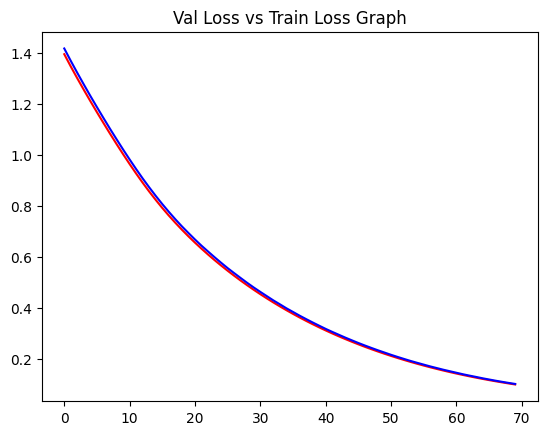

In [46]:
# summarize history for loss



plt.plot(history.history['val_loss'], color='r', label='Val Loss')
plt.plot(history.history['loss'], color='b', label='Train Loss')
plt.title('Val Loss vs Train Loss Graph')
plt.show()

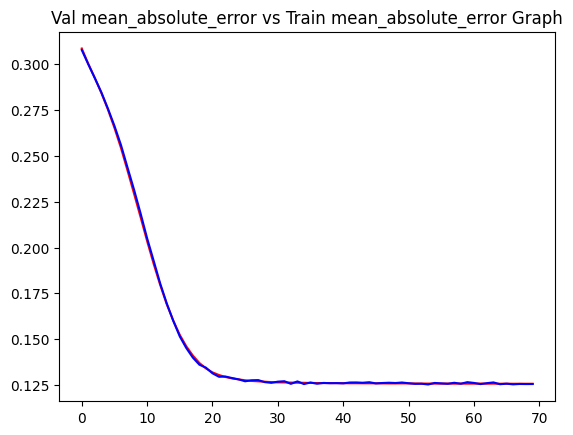

In [47]:
plt.plot(history.history['val_mean_absolute_error'], color='r', label='Val mean_absolute_error')
plt.plot(history.history['mean_absolute_error'], color='b', label='Train mean_absolute_error')
plt.title('Val mean_absolute_error vs Train mean_absolute_error Graph')
plt.show()

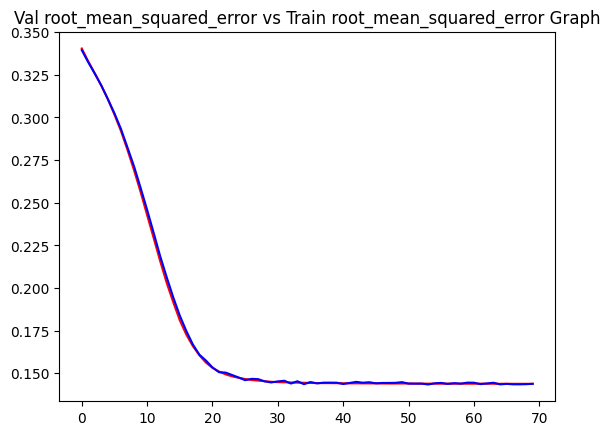

In [48]:
plt.plot(history.history['val_root_mean_squared_error'], color='r', label='Val root_mean_squared_error')
plt.plot(history.history['root_mean_squared_error'], color='b', label='Train root_mean_squared_error')
plt.title('Val root_mean_squared_error vs Train root_mean_squared_error Graph')
plt.show()

#Test

In [49]:
new_id = 2001
new_Mobilitas = 2
new_Penyakitlain = 0
new_Hipertensi = 0
new_Diabetes = 1
new_Reumatik = 0
new_Penyakitjantung = 0
new_Asma = 0
new_Stroke = 1
new_Mengurusrumah = 1
new_Membantupergerakandanaktivitasfisik = 4
new_Membantukonsumsiobatdanmakanan = 4
new_Mengecekkesehatanrutinsecaramandiri = 1 
new_Mendampingidanmenjaga = 4
new_Memasangkanalatmediskhusus = 1
new_Memeriksakanrutinkedokter = 1
new_Indonesia = 0
new_Inggris = 0
new_Jawa = 1
new_Sunda = 0
new_Melayu = 0

lansia_vec = np.array([new_Mobilitas, new_Penyakitlain, new_Hipertensi,
                        new_Diabetes, new_Reumatik, new_Penyakitjantung, new_Asma,
                        new_Stroke, new_Mengurusrumah, new_Membantupergerakandanaktivitasfisik,
                        new_Membantukonsumsiobatdanmakanan, new_Mengecekkesehatanrutinsecaramandiri,
                        new_Mendampingidanmenjaga, new_Memasangkanalatmediskhusus,
                        new_Memeriksakanrutinkedokter, new_Indonesia, new_Inggris, new_Jawa,
                        new_Sunda, new_Melayu])

In [50]:
#For Numeric Input
caregiver_vecs = np.array(caregiver_input)

# generate and replicate the user vector to match the number movies in the data set.
lansia_vecs = gen_user_vecs(lansia_vec,len(caregiver_vecs))

In [51]:
# For City Input

new_lansia_city = "KABUPATEN NGAWI"
new_lansia_city = preprocess_city(new_lansia_city)

In [52]:
# scale our user and item vectors
scaled_user_vecs = scalerLansia.transform(lansia_vecs)
scaled_item_vecs = scalerCaregiver.transform(caregiver_vecs)

# make a prediction
y_p = model.predict([scaled_user_vecs, scaled_item_vecs])

63/63 [==============================] - 0s 955us/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [53]:
y_p

array([[0.80711836],
       [0.8067717 ],
       [0.8071796 ],
       ...,
       [0.8071503 ],
       [0.80716527],
       [0.80721503]], dtype=float32)

In [54]:
#Concate list caregiver city and new lansia city
for_similarity = list_caregiver_city
for_similarity.append(new_lansia_city)

In [55]:
#New_lansia city in the end of concatenated list
for_similarity[-1]

'kabupaten ngawi'

In [56]:
#Use pretrain model to calculate city similarity
embed = hub.load("https://tfhub.dev/google/nnlm-id-dim128-with-normalization/2")
embeddings = embed(for_similarity)

In [57]:
#City similarity output is between -1 and 0. -1 is same word.
#Store output as city weight
city_weight = []
for i in range(len(embeddings)-1):
  const = tf.keras.losses.cosine_similarity(embeddings[-1],embeddings[i],axis=-1)
  city_weight.append(const.numpy())

In [58]:
city_weight

[-0.5065631,
 -0.64823425,
 -0.3267044,
 -0.5742456,
 -0.49790335,
 -0.47426867,
 -0.5638452,
 -0.38039994,
 -0.4102667,
 -0.5814264,
 -0.5500485,
 -0.5967436,
 -0.46003014,
 -0.73569083,
 -0.48254,
 -0.5106916,
 -0.61765766,
 -0.64442784,
 -0.6419412,
 -0.5257158,
 -0.6285084,
 -0.45577133,
 -0.607982,
 -0.6480897,
 -0.4810769,
 -0.61584944,
 -0.5814264,
 -0.5278097,
 -0.55948013,
 -0.62668025,
 -0.57411486,
 -0.4896152,
 -0.42497024,
 -0.63962996,
 -0.3202917,
 -0.5622406,
 -0.5788287,
 -0.5342525,
 -0.47492486,
 -0.605828,
 -0.64442784,
 -0.61584944,
 -0.6695462,
 -0.6355389,
 -0.5892082,
 -0.58958095,
 -0.6219036,
 -0.620453,
 -0.42207208,
 -0.47545505,
 -0.5893343,
 -0.60599273,
 -0.4250773,
 -0.495644,
 -0.6073918,
 -0.59226966,
 -0.63491607,
 -0.499124,
 -0.60408354,
 -0.4559496,
 -0.37144756,
 -0.6486381,
 -0.3973114,
 -0.517806,
 -0.5333479,
 -0.5622406,
 -0.5817302,
 -0.54409146,
 -0.6697743,
 -0.61584944,
 -0.620453,
 -0.5650068,
 -0.47401863,
 -0.5650068,
 -0.5609112,
 -0.5

In [59]:
y_p.shape

(2000, 1)

In [60]:
len(city_weight)

2000

In [61]:
y_p

array([[0.80711836],
       [0.8067717 ],
       [0.8071796 ],
       ...,
       [0.8071503 ],
       [0.80716527],
       [0.80721503]], dtype=float32)

In [62]:
#Final matching score calculate by multiply y_p and minus city weight in the same index
final_score = []
for i in range(2000):
  skor = y_p[i] * -city_weight[i]
  final_score.append(skor[0])

In [63]:
#Get recommended caregiver ids
ids = get_id(final_score)

In [64]:
for id in ids[:20]:
  print(caregiver_df[caregiver_df['id']==id].values)

[[1421 0 1 6 5 27 0.71 0 1 0 1 1 0 0 1 0 0 1 1 'KABUPATEN NGAWI' 820000
  0.8938333920856636]]
[[135 1 5 2 2 25 0.71 0 0 1 1 1 1 0 1 1 1 1 0 'KABUPATEN NGAWI' 1650000
  0.8051788731402976]]
[[670 1 5 4 3 33 0.43 1 0 0 1 0 1 0 1 1 1 0 0 'KABUPATEN NGAWI' 880000
  0.5830162564565166]]
[[119 1 5 2 1 31 1.0 1 1 0 0 0 0 0 0 0 1 1 0 'KABUPATEN NGAWI' 510000
  0.8893718650075061]]
[[809 1 3 5 5 27 0.29 1 1 0 1 0 1 1 0 0 0 1 0 'KABUPATEN NGAWI' 910000
  0.8337572491791858]]
[[328 1 5 1 1 39 0.14 0 0 1 0 0 0 0 1 0 1 0 0 'KABUPATEN NGAWI' 1760000
  0.7855131866935322]]
[[881 1 5 0 0 26 0.71 0 0 1 1 0 1 1 0 1 0 1 0 'KABUPATEN NGAWI' 1390000
  1.0]]
[[120 1 3 7 1 31 0.14 1 0 1 0 0 1 1 1 0 1 0 0 'KABUPATEN NGAWI' 1540000
  1.0]]
[[888 1 2 0 0 24 0.43 1 0 1 0 1 0 1 0 0 0 1 1 'KABUPATEN NGAWI' 1890000
  0.637941297673063]]
[[1011 1 5 3 0 23 0.43 0 1 0 0 0 0 1 1 1 1 0 0 'KABUPATEN CIAMIS' 1300000
  0.7261817773130307]]
[[1760 0 2 0 0 28 0.14 0 0 0 0 0 1 0 0 0 1 1 1 'KABUPATEN CIAMIS' 1600000
  0.68598

# Save Model

In [65]:
saved_model_path = "/content/Machine-Learning/Caregiver-Recommendation/Model-Development/Fixed-Model/my_model.h5"
model.save(saved_model_path)

In [66]:
!tensorflowjs_converter --input_format=keras {saved_model_path} /content/Machine-Learning/Caregiver-Recommendation/Model-Development/Fixed-Model/

2023-06-01 07:36:05.392247: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
